The dataset consists of two sets of data. First set tabulates the chemical properties of 6497 variants of wine, _vinho verde_ produced in Minho, Portugal. The second set consists of the corresponding quality of the variants. The quality was assessed by three tasters using blind tastes. The quality is gauged on 1-10 rating scale. The problem is to build a model to map the chemical properties of the wine to its quality.

The data is taken from ucimlrepo. Instruction for obtaining data was obtained from https://archive.ics.uci.edu/dataset/186/wine+quality

In [ ]:
pip install ucimlrepo

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn import tree, ensemble
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
wine_original = wine_quality.data.features
quality_original = wine_quality.data.targets

# metadata
#print(wine_quality.metadata)

# variable information
#print(wine_quality.variables)

In [3]:
#split the given dataset into training and test dataset
#test_size is proportion of total data used as test data
#X and Y respectively are the attributes and targets
def train_test_split(X, Y, test_size=0.2):
  #convert the proportion to index range for test data
  test_size = int(test_size*len(X))

  #seed the generator so that same permutation is generated everytime dataset is loaded
  rng = np.random.default_rng(seed=100)
  shuffled_indices = rng.permutation(len(X))

  X_test = X.iloc[shuffled_indices[:test_size]]
  Y_test = Y.iloc[shuffled_indices[:test_size]]
  X_train = X.iloc[shuffled_indices[test_size:]]
  Y_train = Y.iloc[shuffled_indices[test_size:]]

  return X_train, Y_train, X_test, Y_test

In [4]:
#split the data into train and test dataset while keeping the original dataset
wine, quality, wine_test, quality_test = train_test_split(wine_original, quality_original)

In [5]:
#the new set of data carry their original indices from wine_original and quality_original
#reset the index columns
for x in [wine, quality, wine_test, quality_test]:
  x.reset_index(drop=True, inplace=True)

The data is highly imbalanced as can be seen from the _quality_ distribution.

In [6]:
wine.loc[:, 'quality'] = quality.loc[:, 'quality']

/tmp/ipykernel_777816/644229156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine.loc[:, 'quality'] = quality.loc[:, 'quality']


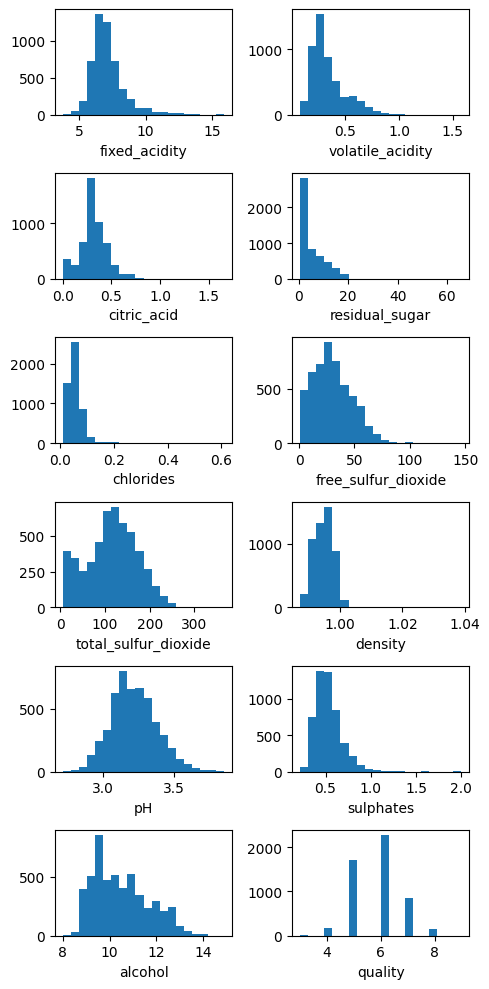

In [ ]:
frequency_dist, attributes = plt.subplots(6, 2, figsize=(5,10))
for i in range(6):
  for j in range(2):
    label = wine.columns[2*i + j]
    attributes[i, j].hist(wine[label], bins=20)
    attributes[i, j].set_xlabel(label)
frequency_dist.tight_layout()

In [7]:
data_description = wine.describe()
data_description.loc["IQR", :] = data_description.loc["75%", :] - data_description.loc["25%", :]
data_description.loc["skew", :] = wine.skew()
data_description.loc["kurtosis", :] = wine.kurtosis()
data_description

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,5198.000000,5198.000000,5198.000000,5198.000000,5198.000000,5198.000000,5198.000000,5198.000000,5198.000000,5198.000000,5198.000000,5198.000000
mean,7.215217,0.339066,0.318898,5.453011,0.056132,30.533282,115.879761,0.994705,3.218388,0.532028,10.489779,5.812620
std,1.292957,0.163083,0.145187,4.792981,0.035190,17.513736,56.391918,0.003016,0.160184,0.151328,1.186915,0.871534
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,78.000000,0.992300,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994880,3.200000,0.510000,10.300000,6.000000
75%,7.700000,0.410000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,146.500000,366.500000,1.038980,3.850000,2.000000,14.900000,9.000000
IQR,1.300000,0.180000,0.140000,6.300000,0.027000,24.000000,78.000000,0.004700,0.210000,0.170000,1.800000,1.000000
skew,1.750178,1.480429,0.490425,1.505057,5.482933,0.817798,-0.022109,0.635119,0.357424,1.937195,0.548702,0.178316


In [8]:
pearson_corr_matrix = wine.corr(method='pearson')
pearson_corr_matrix
#wine.corrwith(quality['quality']).sort_values(ascending=False)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,1.000000,0.225404,0.321372,-0.109953,0.295063,-0.279233,-0.319337,0.455445,-0.253500,0.291750,-0.093021,-0.075394
volatile_acidity,0.225404,1.000000,-0.382823,-0.190355,0.381456,-0.358572,-0.415709,0.277801,0.252342,0.226832,-0.045312,-0.275159
citric_acid,0.321372,-0.382823,1.000000,0.140403,0.026869,0.139483,0.203090,0.091873,-0.323262,0.051746,-0.007312,0.088422
residual_sugar,-0.109953,-0.190355,0.140403,1.000000,-0.131343,0.412193,0.497664,0.557675,-0.268984,-0.187564,-0.358438,-0.036204
chlorides,0.295063,0.381456,0.026869,-0.131343,1.000000,-0.194192,-0.279738,0.357859,0.047358,0.405851,-0.252338,-0.199297
free_sulfur_dioxide,-0.279233,-0.358572,0.139483,0.412193,-0.194192,1.000000,0.717776,0.031656,-0.146771,-0.189034,-0.178087,0.067341
total_sulfur_dioxide,-0.319337,-0.415709,0.203090,0.497664,-0.279738,0.717776,1.000000,0.038377,-0.242890,-0.272557,-0.266036,-0.039408
density,0.455445,0.277801,0.091873,0.557675,0.357859,0.031656,0.038377,1.000000,0.007726,0.252464,-0.685170,-0.306478
pH,-0.253500,0.252342,-0.323262,-0.268984,0.047358,-0.146771,-0.242890,0.007726,1.000000,0.181938,0.120133,0.015092
sulphates,0.291750,0.226832,0.051746,-0.187564,0.405851,-0.189034,-0.272557,0.252464,0.181938,1.000000,-0.008547,0.028793


In [9]:
spearman_corr_matrix = wine.corr(method='spearman')
spearman_corr_matrix

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,1.000000,0.208947,0.262216,-0.031573,0.355129,-0.253242,-0.227650,0.429669,-0.252623,0.218042,-0.110960,-0.097023
volatile_acidity,0.208947,1.000000,-0.298791,-0.061581,0.423172,-0.367134,-0.340951,0.268049,0.186863,0.255074,-0.034395,-0.265154
citric_acid,0.262216,-0.298791,1.000000,0.076686,-0.083496,0.128004,0.163079,0.060027,-0.280639,0.030918,0.022419,0.107528
residual_sugar,-0.031573,-0.061581,0.076686,1.000000,-0.043798,0.393209,0.460869,0.529445,-0.233249,-0.143521,-0.333055,-0.021854
chlorides,0.355129,0.423172,-0.083496,-0.043798,1.000000,-0.267219,-0.273126,0.582427,0.167717,0.372654,-0.396311,-0.298240
free_sulfur_dioxide,-0.253242,-0.367134,0.128004,0.393209,-0.267219,1.000000,0.737340,0.012214,-0.163257,-0.219110,-0.183167,0.090429
total_sulfur_dioxide,-0.227650,-0.340951,0.163079,0.460869,-0.273126,0.737340,1.000000,0.067927,-0.246018,-0.258727,-0.310756,-0.054954
density,0.429669,0.268049,0.060027,0.529445,0.582427,0.012214,0.067927,1.000000,0.006209,0.270123,-0.703780,-0.327871
pH,-0.252623,0.186863,-0.280639,-0.233249,0.167717,-0.163257,-0.246018,0.006209,1.000000,0.251370,0.142648,0.029336
sulphates,0.218042,0.255074,0.030918,-0.143521,0.372654,-0.219110,-0.258727,0.270123,0.251370,1.000000,0.003923,0.022580


We see that the several features exhibit linear correlation. Thus multicollinearity needs to be taken into account in the regression model else the model will suffer from overfitting.

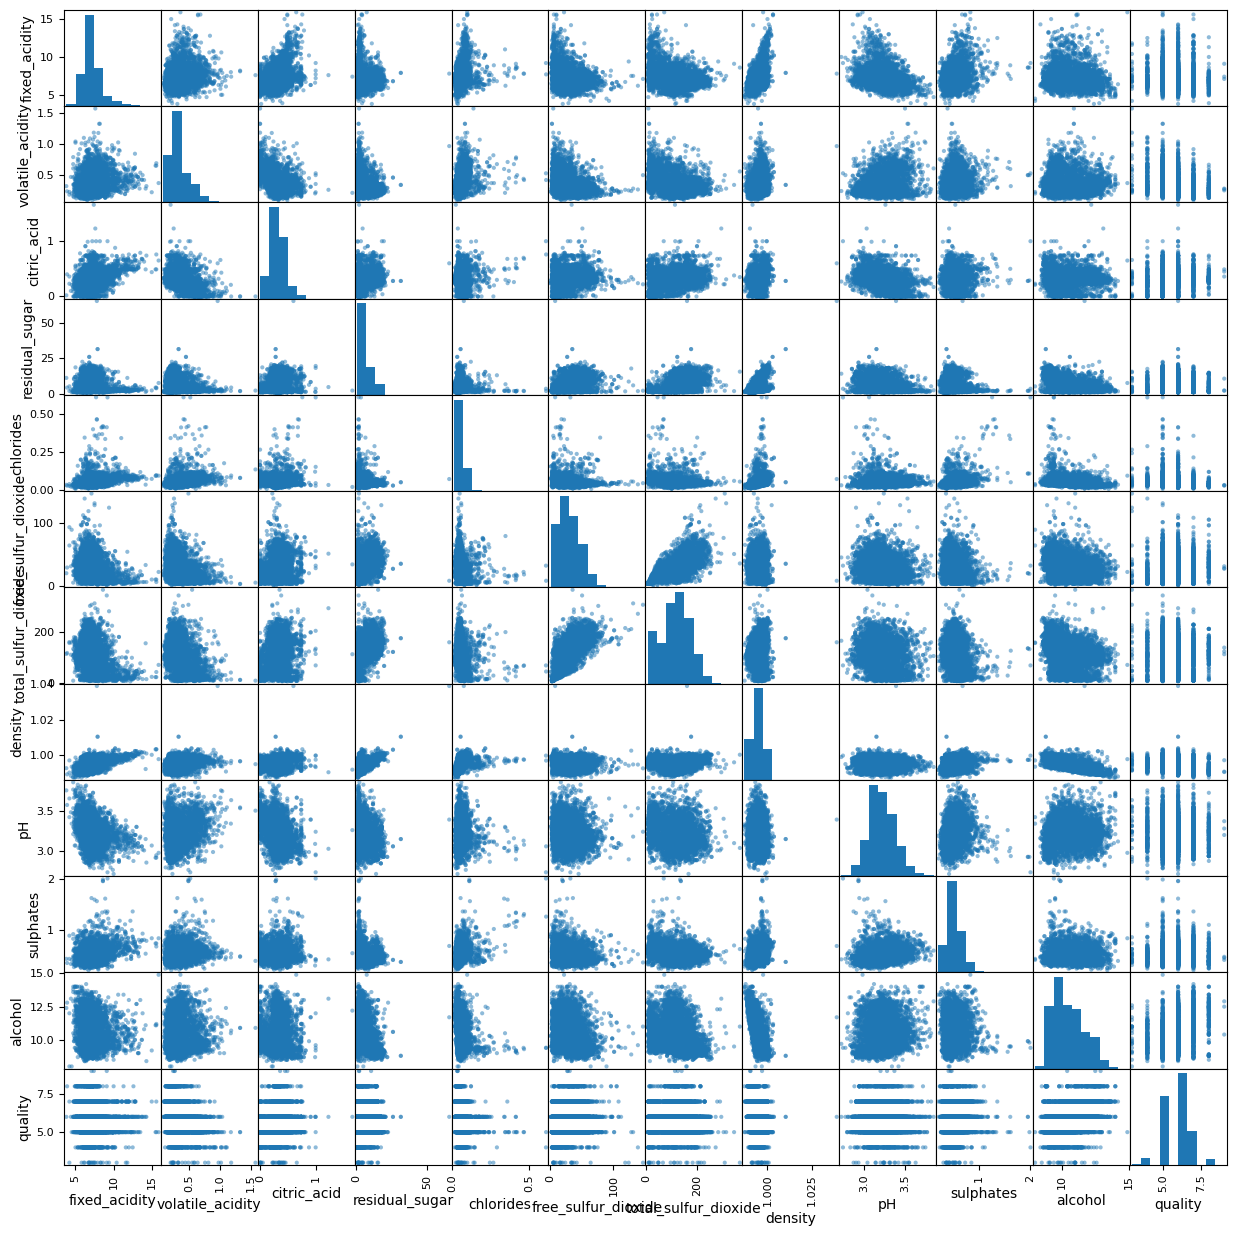

In [ ]:
scatter_plot = pd.plotting.scatter_matrix(wine, figsize=(15,15))

We note the following:


1.   From the target (quality) distribution, we see that the most of the target values are concentrated on 5,6,7. The data is thus, highly imbalanced.
2.   There are outliers in the attributes.
3.   Some attributes are postively skewed.
4.   Some attributes are linearly correlated. So, the data exhibit multicollinearity.



In [10]:
#Remove the outliers. Keep only values which are less than Q3 + 1.5*IQR
Q3 = data_description.loc['75%', :]
IQR = data_description.loc['IQR', :]
for x in wine.loc[:, wine.columns != 'quality']:#wine.columns.drop('quality'):
  wine = wine[wine[x] < Q3[x] + 1.5*IQR[x]]
wine.reset_index(drop=True, inplace=True)

In [11]:
quality = quality.iloc[0:0]
quality.loc[:, 'quality'] = wine.loc[:, 'quality']
#quality.dropna(subset=['quality'], inplace=True)
wine.drop('quality', axis=1, inplace=True)

In [ ]:
data_description.loc['IQR',:]

fixed_acidity            1.3000
volatile_acidity         0.1800
citric_acid              0.1400
residual_sugar           6.3000
chlorides                0.0270
free_sulfur_dioxide     24.0000
total_sulfur_dioxide    78.0000
density                  0.0047
pH                       0.2100
sulphates                0.1700
alcohol                  1.8000
quality                  1.0000
Name: IQR, dtype: float64

IndexError: index 11 is out of bounds for axis 0 with size 11

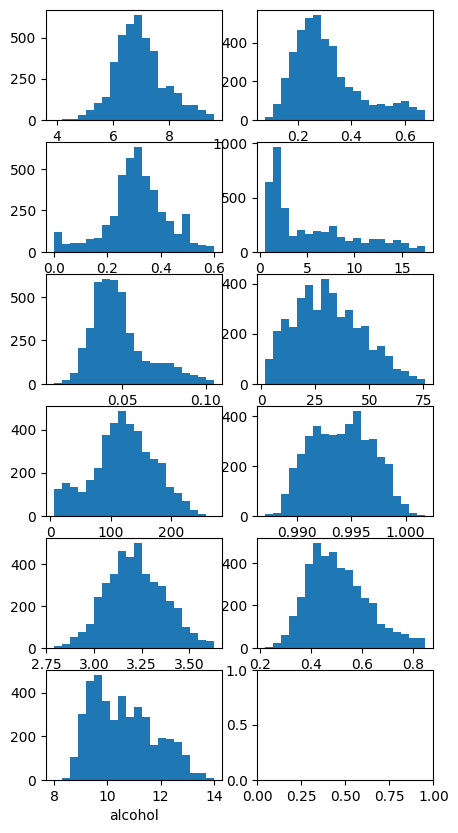

In [ ]:
frequency_dist, attributes = plt.subplots(6, 2, figsize=(5,10))
for i in range(6):
  for j in range(2):
    label = wine.columns[2*i + j]
    attributes[i, j].hist(wine[label], bins=20)
    attributes[i, j].set_xlabel(label)
frequency_dist.tight_layout()

# Multilinear Regression Model

In [12]:
#takes training data and calculates linear regression parameters: weights and bias.
#It takes features as (N, n) matrix, and target as (N, 1) matrix, where N is the training size and n is the feature size.
#The output is a weight array of dimension (1, n) and a bias as float.
def linearRegression(X, Y, threshold=0.001, learning_rate=0.0001, type="MSE"):
  N = len(X)
  X.loc[:, '1s'] = np.ones(N)
  param = np.linalg.lstsq(X, Y, rcond=None)
  return param[0][:-1], param[0][-1], param[1]

In [13]:
W, B, _ = linearRegression(wine, quality.loc[:, 'quality'])
W = W.reshape((1, len(W)))

LinAlgError: Incompatible dimensions

In [ ]:
print(W)
print(B)

[[ 1.11465799e-01 -1.28163088e+00 -1.38681940e-01  6.25297105e-02
   3.31911908e-01  8.01043732e-03 -2.53471311e-03 -9.22694211e+01
   7.39942202e-01  8.91051799e-01  2.36626699e-01]]
91.6346500467236


## Square sums

In [ ]:
wine.drop('1s', axis=1, inplace=True)

In [ ]:
def modelAccuracy(X, Y, W, B):
  Residual_error = pd.DataFrame()
  Residual_error = Y
  Residual_error.loc[:, 'predicted_quality'] = np.dot(X, W.T) + B
  Residual_error.loc[:, 'residual'] = Residual_error.loc[:, 'predicted_quality'] - Y.loc[:, 'quality']
  #calculate the squared sums from variances
  squared_sum = Residual_error.var()
  squared_sum *= len(X)-1
  #rename the column names which stores squared sums
  squared_sum.rename(index={'quality': 'SSTO', 'residual': 'SSE', 'predicted_quality': 'SSR'}, inplace=True)
  #calculate coefficient of determination
  squared_sum.loc['r2'] = squared_sum.loc['SSR']/squared_sum.loc['SSTO']
  from statsmodels.stats.outliers_influence import variance_inflation_factor
  from statsmodels.tools.tools import add_constant
  X = add_constant(X)
  VIF = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
  return squared_sum, VIF


In [ ]:
train_param, train_VIF = modelAccuracy(wine, quality, W, B)
test_param, test_VIF = modelAccuracy(wine_test, quality_test, W, B)

In [ ]:
def plot_table(train_param, test_param):
  fig, ax = plt.subplots()
  ax.axis('off')
  parameters = pd.DataFrame()
  parameters.loc['train', train_param.index] = train_param.round(4)
  parameters.loc['test', test_param.index] = test_param.round(4)
  table = pd.plotting.table(ax, parameters.T, loc='upper right', cellLoc='center')
  table.set_fontsize(14)
  table.auto_set_font_size(False)
  table.set_fontsize(12)
  table.scale(0.6, 2.3)

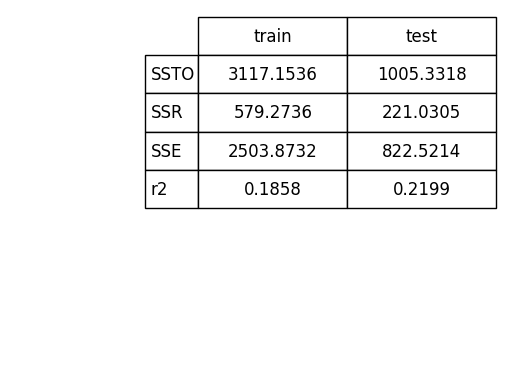

In [ ]:
plot_table(train_param, test_param)

## VIF

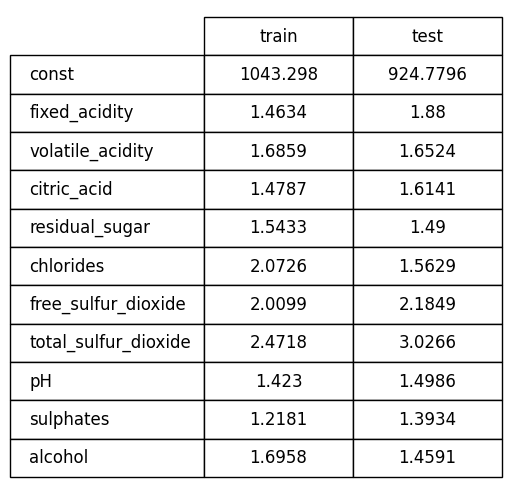

In [ ]:
plot_table(train_VIF, test_VIF)

We see that density has very high VIF value. So, we need to drop the density attribute.

In [ ]:
#delete the density attribute and its corresponding weight
X = wine.drop(['density'], axis=1)
weights = np.delete(W, wine.columns.get_loc('density'))

In [ ]:
train_param, train_VIF = modelAccuracy(X, quality, weights, B)
test_param, test_VIF = modelAccuracy(wine_test.drop(['density'], axis=1), quality_test, weights, B)

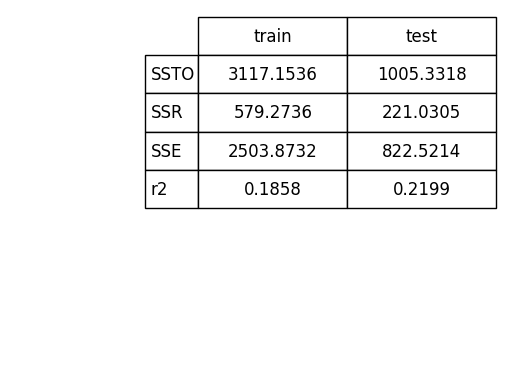

In [ ]:
plot_table(train_param, test_param)

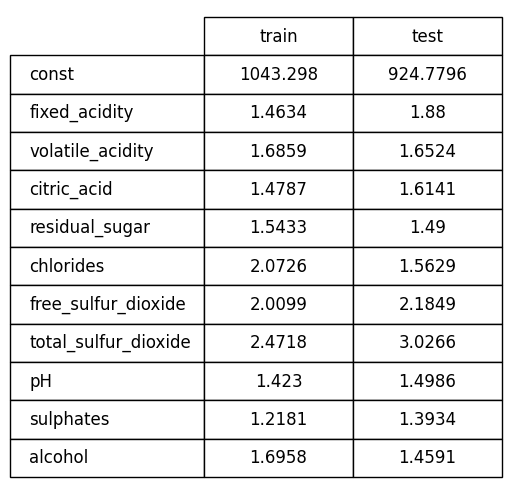

In [ ]:
plot_table(train_VIF, test_VIF)

# Classification Methods

In [ ]:
#the target is ordinal value 0-10.
#categorize the target value into 'Low', 'Medium', and 'High'
def categorize(X):
  l1 = X.quality<6
  l2 = X.quality==6
  l3 = X.quality>=7
  X.loc[l1, 'quality'] = 'Low'
  X.loc[l2, 'quality'] = 'Medium'
  X.loc[l3, 'quality'] = 'High'

In [ ]:
categorize(quality)

In [ ]:
categorize(quality_test)

## Decision Tree Classifer

In [ ]:
#use Decision tree method to fit the training data

DT_classifier = tree.DecisionTreeClassifier()
DT_classifier = DT_classifier.fit(wine, quality)

In [ ]:
#predict the target on test data
quality_prediction_DT = pd.DataFrame(DT_classifier.predict(wine_test), columns=['quality'])

In [ ]:
#calculates the total number of correct predictions and accuracy of the model
def calculateMetrics(test, prediction):
  total_correct_prediction = test['quality'].eq(prediction['quality']).sum()
  #calculat the accuracy of the prediction
  accuracy = 100*(total_correct_prediction/len(test))
  return total_correct_prediction, accuracy

In [ ]:
total_correct_prediction, accuracy = calculateMetrics(quality_test, quality_prediction_DT)

In [ ]:
print("Out of " + str(len(quality_test) + ", " + str(total_correct_prediction) + " were correctly predicted")
print("The accuracy achieved by the Decision Tree model is " + str(accuracy))

833
64.12625096227868


In [ ]:
#constructs a table to juxtapose the predictions with the true values in test data
def misclassificationTable(test, prediction):
  misclassification_table = pd.DataFrame()
  for x in ['Low', 'Medium', 'High']:
    for y in ['Low', 'Medium', 'High']:
      misclassification_table.loc[x, y] = sum((test['quality'] == y) & (prediction['quality'] == x))
  return misclassification_table

In [ ]:
misclassificationTable(quality_test, quality_prediction_DT).head()

,Low,Medium,High
Low,313.0,125.0,23.0
Medium,137.0,345.0,71.0
High,21.0,89.0,175.0


## Random Froest Classifier

In [ ]:
RF_classifier = ensemble.RandomForestClassifier()
RF_classifier.fit(wine, quality.to_numpy().ravel())

In [ ]:
quality_prediction_RF = pd.DataFrame(RF_classifier.predict(wine_test), columns=['quality'])

In [ ]:
total_correct_prediction_RF, accuracy_RF = calculateMetrics(quality_test, quality_prediction_RF)

In [ ]:
print(total_correct_prediction_RF)
print(accuracy_RF)

942
72.51732101616628


In [ ]:
misclassificationTable(quality_test, quality_prediction_RF).head()

,Low,Medium,High
Low,356.0,100.0,2.0
Medium,108.0,409.0,90.0
High,7.0,50.0,177.0


In [ ]:
"""calculate the oob score for the model for different number of trees"""
#minimum and maximum number of trees in the forest
min_estimator = 5
max_estimator = 150
estimator_range = np.arange(min_estimator, max_estimator+1, 5)

error = np.zeros(shape=(len(estimator_range), 2))

#set the oob_score to true
RF_classifier = ensemble.RandomForestClassifier(warm_start=True, oob_score=True)
raveled_quality = quality.to_numpy().ravel()

for i, x in enumerate(estimator_range):
  RF_classifier.set_params(n_estimators=x)
  RF_classifier.fit(wine, raveled_quality)
  error[i,0] = x
  error[i,1] = (1 - RF_classifier.oob_score_)

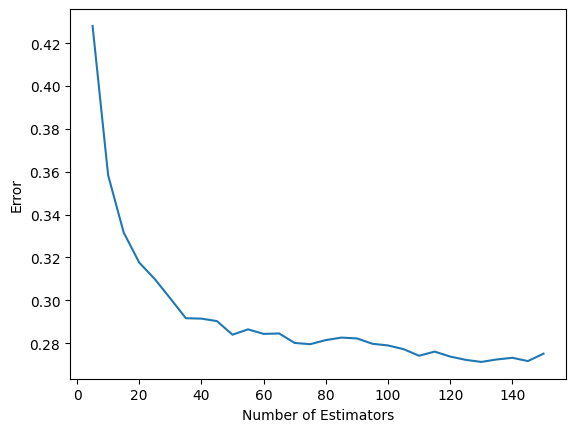

In [ ]:
plt.plot(error[:,0], error[:,1])
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.show()